## Gathering the data -- using Google BigQuery

Process:
    
1. create a project and project dataset in BigQuery
2. Query big data (see three used in this project queries below)
3. save/copy the query results into a table
4. export the dataset table into a csv file

-- QUERY 1
-- What is the most common factor in a motor vehicle collision in Brooklyn? 
-- This query counts the number of collisions for each collision type, in descending order.

SELECT
  contributing_factor_vehicle_1 AS collision_factor,
  COUNT(*) num_collisions
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  contributing_factor_vehicle_1 != "Unspecified"
  AND contributing_factor_vehicle_1 != ""
  AND borough = "BROOKLYN"
  AND cast(timestamp as date) between "2014-01-01" AND "2017-12-31"
GROUP BY
  1
ORDER BY
  num_collisions DESC

-- QUERY 2
-- What are the most dangerous streets for motor vehicle collisions in Brooklyn? 
-- This query counts the number of fatalities and injured by streets. 
#standardSQL
SELECT
  on_street_name,
  SUM(number_of_persons_killed) AS deaths,
  SUM(number_of_persons_injured) AS injuries
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  on_street_name <> ''
  AND borough = "BROOKLYN"
  AND cast(timestamp as date) between "2014-01-01" AND "2017-12-31"
GROUP BY
  on_street_name
ORDER BY
  deaths DESC
LIMIT
  10


-- QUERY 3
-- What is the most common factor in a motor vehicle collision in NYC's Brooklyn? and what other details can we garner from Brooklyn incidents when looking at primary collision factors? 
-- This query counts the number of fatalities by streets. 


-- check for weird spelling of Brooklyn
#standardSQL
SELECT
  DISTINCT(borough)
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`

SELECT
  *
FROM
  `bigquery-public-data.new_york.nypd_mv_collisions`
WHERE
  borough = "BROOKLYN"
  AND cast(timestamp as date) between "2014-01-01" AND "2017-12-31"

In [22]:
%matplotlib inline
import os
from google.cloud import bigquery

#please refer to https://cloud.google.com/bigquery/docs/use-service-accounts to obtain your CREDENTIALS 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'linkedininsightscase-9ef4c28fb738.json'

In [2]:
client = bigquery.Client()

In [17]:
sql = """
SELECT *
FROM `bigquery-public-data.new_york_mv_collisions.nypd_mv_collisions`
WHERE borough = "BROOKLYN"
AND cast(timestamp as date) between "2014-01-01" AND "2017-12-31"
ORDER BY timestamp ASC
"""

#pct_overlap_terms_by_days_apart.head()

In [18]:
query_job = client.query(sql).to_dataframe()
query_job.to_csv('bigquery_nypd_collisions.csv')

### Loading

In [23]:

## Loading in packages
import csv
import pandas as pd
import numpy as np #import the stats library from numpy
from scipy import stats
from datetime import datetime

#%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from collections import defaultdict

import seaborn as sns

import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [86]:
## read the csv pulled from the database
brooklyn_data = pd.read_csv('bigquery_nypd_collisions.csv')
brooklyn_data = brooklyn_data.applymap(lambda x: x.strip() if isinstance(x, str) else x) ## trim up white space across the datatable 

### Exploratory


In [87]:
brooklyn_data.head()

,borough,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,cross_street_name,timestamp,latitude,longitude,...,number_of_persons_killed,off_street_name,on_street_name,unique_key,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,zip_code
0,BROOKLYN,Unspecified,Unspecified,Unspecified,NaN,NaN,NORTH 3 STREET,2014-06-12T16:00:00.000Z,40.716384,-73.961423,...,0,NaN,BERRY STREET,352535,MOTORCYCLE,MOTORCYCLE,UNKNOWN,NaN,NaN,11249.0
1,BROOKLYN,Unspecified,NaN,NaN,NaN,NaN,BERRIMAN STREET,2017-12-18T07:00:00.000Z,40.676765,-73.880516,...,0,NaN,LIBERTY AVENUE,3812120,SPORT UTILITY / STATION WAGON,trail,NaN,NaN,NaN,11208.0
2,BROOKLYN,Lost Consciousness,NaN,NaN,NaN,NaN,STUYVESANT AVENUE,2014-01-17T08:30:00.000Z,40.688232,-73.933101,...,0,NaN,GATES AVENUE,184352,PASSENGER VEHICLE,AMBULANCE,NaN,NaN,NaN,11221.0
3,BROOKLYN,NaN,NaN,NaN,NaN,NaN,AVENUE J,2016-04-08T16:45:00.000Z,40.625389,-73.959502,...,0,NaN,EAST 17 STREET,3417441,PASSENGER VEHICLE,MOTORCYCLE,NaN,NaN,NaN,11230.0
4,BROOKLYN,Unspecified,NaN,NaN,NaN,NaN,BUSHWICK AVENUE,2015-03-28T20:00:00.000Z,40.705256,-73.939432,...,0,NaN,MCKIBBIN STREET,3194093,VAN,AMBULANCE,NaN,NaN,NaN,11206.0


In [131]:
brooklyn_data['timestamp'] = pd.to_datetime(brooklyn_data['timestamp'])
brooklyn_data['hour'] = brooklyn_data['timestamp'].dt.hour
brooklyn_data['month'] = brooklyn_data['timestamp'].dt.month
brooklyn_data['weekday'] = brooklyn_data['timestamp'].dt.day_of_week + 1#The day of the week with Monday=1, Sunday=7


count    190906.000000
mean          3.868344
std           1.954568
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           7.000000
Name: weekday, dtype: float64

Explore when the accidents happen during the day, maybe it is during the evening with low visibility?

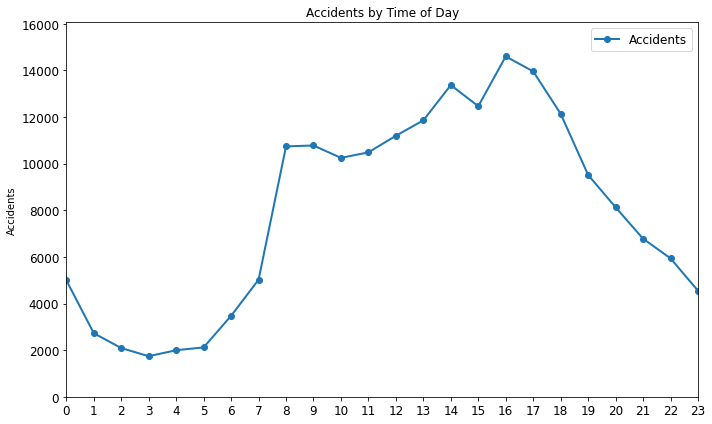

In [89]:


# Count the frequency of accidents for each hour
hour_freq = brooklyn_data['hour'].value_counts().sort_index()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(hour_freq.index, hour_freq.values, marker='o', linestyle='-', color='#1f77b4', linewidth=2)

# Set the x-axis labels
plt.xticks(hour_freq.index, fontsize = 12)
plt.xlim(0, max(hour_freq.index))

# Set the y-axis label
plt.ylabel('Accidents')
plt.yticks(fontsize=12)
plt.ylim(0, max(hour_freq.values) * 1.1)  # Set the y-axis limit

# Add a legend
plt.legend(['Accidents'], fontsize=12)

# Set the title
plt.title('Accidents by Time of Day')

# Display the plot
plt.tight_layout()
plt.show()


#### Insight 1: The accidents happen during business hours mostly from 8AM to 6pm. 

Now we want to see if there is a seasonal affect to this, maybe there is more accidents in Winter months?

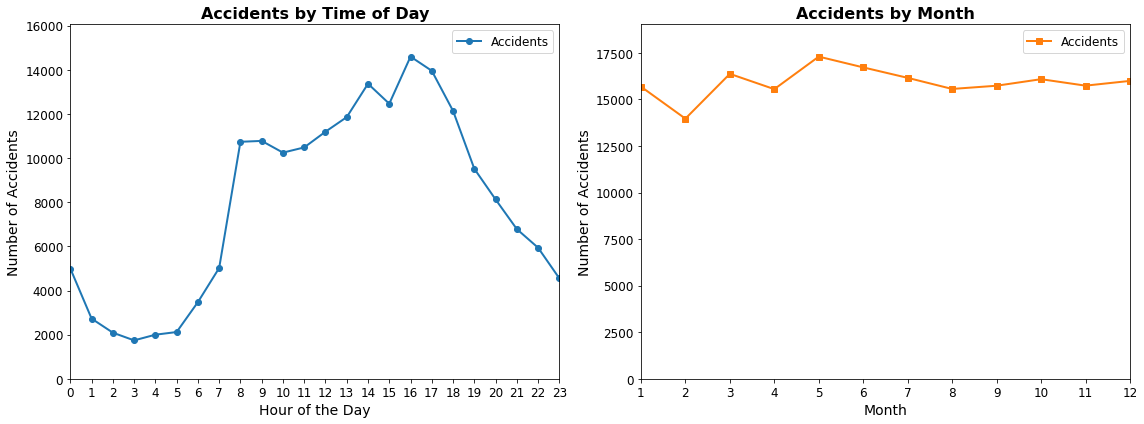

In [90]:


# Count the frequency of accidents for each hour
month_freq = brooklyn_data['month'].value_counts().sort_index()

# Create the plot
hour_freq = brooklyn_data['hour'].value_counts().sort_index()
month_freq = brooklyn_data['month'].value_counts().sort_index()

# Create a single plot
hour_freq = brooklyn_data['hour'].value_counts().sort_index()
month_freq = brooklyn_data['month'].value_counts().sort_index()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot accidents by hour
ax1.plot(hour_freq.index, hour_freq.values, marker='o', linestyle='-', color='#1f77b4', linewidth=2)
ax1.set_xticks(range(0, 24))
ax1.set_xticklabels(range(0, 24), fontsize=12)
ax1.set_xlim(0, max(hour_freq.index))
ax1.set_xlabel('Hour of the Day', fontsize=14)
ax1.set_ylabel('Number of Accidents', fontsize=14)
ax1.set_ylim(0, max(hour_freq.values)*1.1)
ax1.set_title('Accidents by Time of Day', fontsize=16, fontweight='bold')
ax1.legend(['Accidents'], fontsize=12)

# Plot accidents by month
ax2.plot(month_freq.index, month_freq.values, marker='s', linestyle='-', color='#ff7f0e', linewidth=2)
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(range(1, 13), fontsize=12)
ax2.set_xlim(1, max(month_freq.index))
ax2.set_xlabel('Month', fontsize=14)
ax2.set_ylim(0, max(month_freq.values)* 1.1)
ax2.set_ylabel('Number of Accidents', fontsize=14)
ax2.set_title('Accidents by Month', fontsize=16, fontweight='bold')
ax2.legend(['Accidents'], fontsize=12)
# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


#### Insight 2: There is limited season effect to this.

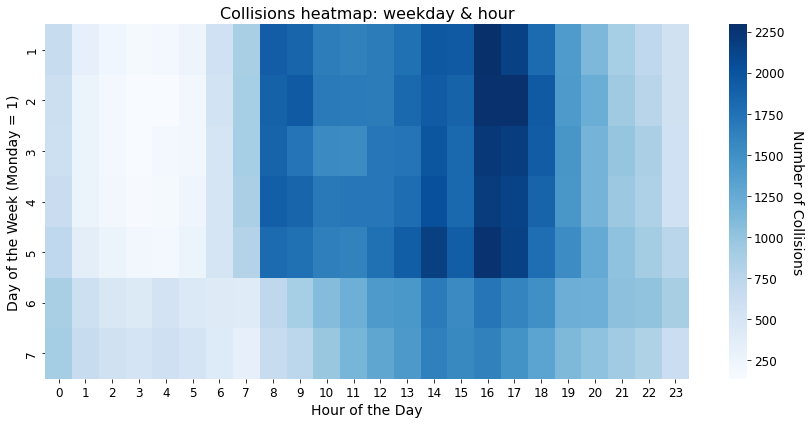

In [153]:
#heatmap of month and dayofthemonth
dayHour = brooklyn_data.groupby(by=['weekday', 'hour']).count()['collision_factor'].unstack()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Set the title
ax.set_title('Collisions heatmap: weekday & hour', fontsize=16)

# Create the heatmap
heatmap = sns.heatmap(dayHour, cmap='Blues', ax=ax)

# Rename the axes
heatmap.set_xlabel('Hour of the Day', fontsize=14)
heatmap.set_ylabel('Day of the Week (Monday = 1)', fontsize=14)

# Add a colorbar legend
cbar = ax.collections[0].colorbar
cbar.set_label('Number of Collisions', labelpad = 20, fontsize=14, rotation = 270)


##plt.figure(figsize=(12, 6))
#plt.title('Collisions heatmap: weekday & hour')
#sns.heatmap(dayHour, cmap='viridis')
plt.tight_layout()
plt.show()


#### Insight 3: Looking closer. Most collisions happen between 8AM and peak at 6PM from Monday to Friday. 

In [91]:
brooklyn_data.dtypes

borough                                       object
contributing_factor_vehicle_1                 object
contributing_factor_vehicle_2                 object
contributing_factor_vehicle_3                 object
contributing_factor_vehicle_4                 object
contributing_factor_vehicle_5                 object
cross_street_name                             object
timestamp                        datetime64[ns, UTC]
latitude                                     float64
longitude                                    float64
location                                      object
number_of_cyclist_injured                      int64
number_of_cyclist_killed                       int64
number_of_motorist_injured                     int64
number_of_motorist_killed                      int64
number_of_pedestrians_injured                  int64
number_of_pedestrians_killed                   int64
number_of_persons_injured                      int64
number_of_persons_killed                      

Driver Inattention/Distraction    24759
Failure to Yield Right-of-Way     11113
Backing Unsafely                   7032
Fatigued/Drowsy                    5654
Other Vehicular                    3925
Following Too Closely              3778
Lost Consciousness                 3534
Turning Improperly                 3237
Traffic Control Disregarded        2885
Prescription Medication            2538
Name: contributing_factor_vehicle_1, dtype: int64


C:\Users\Hoang\AppData\Local\Temp/ipykernel_22032/3049861183.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(factor_freq.index, rotation=45, ha='right', fontsize=12)


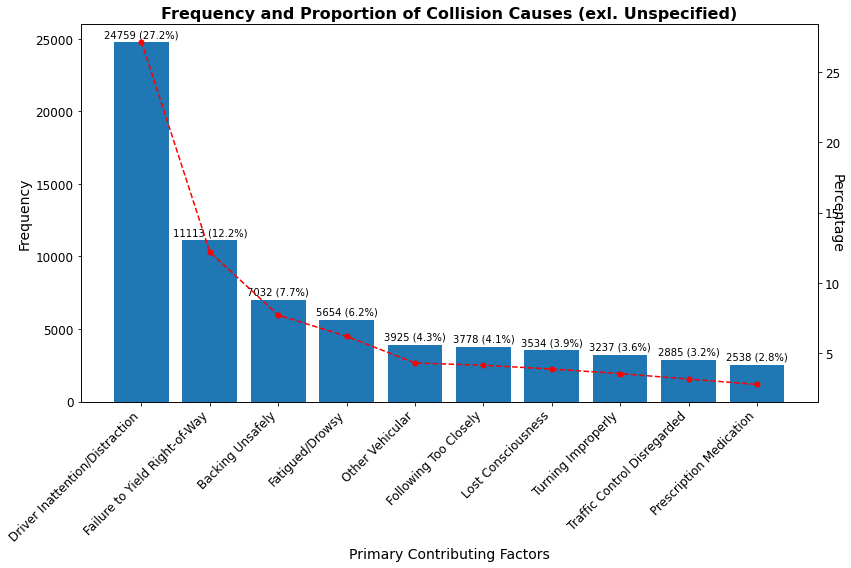

In [126]:
factor_clean = brooklyn_data.loc[brooklyn_data["contributing_factor_vehicle_1"] != "Unspecified", "contributing_factor_vehicle_1"].value_counts()
total_counts = factor_clean.sum()
factor_freq = brooklyn_data.loc[brooklyn_data["contributing_factor_vehicle_1"] != "Unspecified", "contributing_factor_vehicle_1"].value_counts().head(10)

print(factor_freq)

# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create the histogram on the first y-axis
bars = ax1.bar(factor_freq.index, factor_freq.values, color='#1f77b4')
ax1.set_xlabel('Primary Contributing Factors', fontsize=14)
ax1.set_xticklabels(factor_freq.index, rotation=45, ha='right', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the percentage on the second y-axis
ax2.plot(factor_freq.index, (factor_freq / total_counts) * 100, 'r--', marker='o', markersize=5)
ax2.set_ylabel('Percentage', fontsize=14, rotation = 270)
ax2.tick_params(axis='y', labelsize=12)

# Set the title
ax1.set_title('Frequency and Proportion of Collision Causes (exl. Unspecified)', fontsize=16, fontweight='bold')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    proportion = (height / total_counts) * 100  # Calculate the proportion to total
    ax1.annotate('{:.0f} ({:.1f}%)'.format(height, proportion),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')  

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

#### Insight 4: Driver inattention/ distraction is the biggest cause of 

ATLANTIC AVENUE      5318
FLATBUSH AVENUE      3608
LINDEN BOULEVARD     2436
NOSTRAND AVENUE      2424
BEDFORD AVENUE       2253
                     ... 
WYTHE AVE               1
5 ave                   1
VANDERVOORT PLACE       1
remsen avenue           1
Rochester Avenue        1
Name: on_street_name, Length: 1808, dtype: int64
161824


ATLANTIC AVENUE        5318
FLATBUSH AVENUE        3608
LINDEN BOULEVARD       2436
NOSTRAND AVENUE        2424
BEDFORD AVENUE         2253
OCEAN PARKWAY          2206
EASTERN PARKWAY        2189
UTICA AVENUE           2014
CONEY ISLAND AVENUE    1884
KINGS HIGHWAY          1852
PENNSYLVANIA AVENUE    1782
FULTON STREET          1781
4 AVENUE               1645
3 AVENUE               1633
OCEAN AVENUE           1626
Name: on_street_name, dtype: int64


C:\Users\Hoang\AppData\Local\Temp/ipykernel_22032/1122093133.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(street_factor.index, rotation=45, ha='right', fontsize=12)


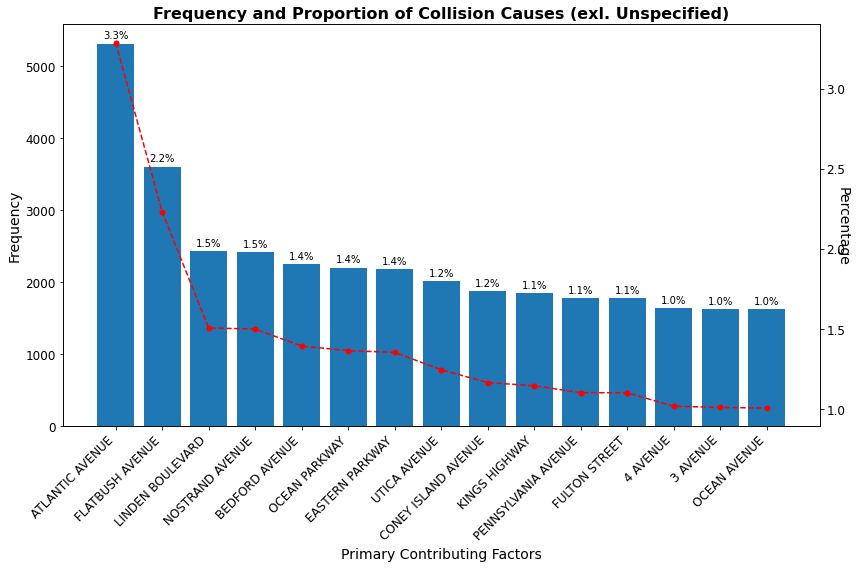

In [166]:
# Now we want to figure out where does these accidents happen the most
street_factor_all = brooklyn_data["on_street_name"].value_counts()
#totalStreetCounts = street_factor_all.sum()
street_factor = brooklyn_data["on_street_name"].value_counts().head(15)
print(street_factor)

# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create the histogram on the first y-axis
street_bars = ax1.bar(street_factor.index, street_factor.values, color='#1f77b4')
ax1.set_xlabel('Primary Contributing Factors', fontsize=14)
ax1.set_xticklabels(street_factor.index, rotation=45, ha='right', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the percentage on the second y-axis
ax2.plot(street_factor.index, (street_factor / totalStreetCounts) * 100, 'r--', marker='o', markersize=5)
ax2.set_ylabel('Percentage', fontsize=14, rotation = 270)
ax2.tick_params(axis='y', labelsize=12)

# Set the title
ax1.set_title('Frequency and Proportion of Collision Causes (exl. Unspecified)', fontsize=16, fontweight='bold')

# Add value labels on top of bars
for bar in street_bars:
    height = bar.get_height()
    proportion = (height / totalStreetCounts) * 100  # Calculate the proportion to total
    ax1.annotate('{:.1f}%'.format(proportion),
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')  

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

#### Insight 5: The top 3 streets (Atlantic, Flatbush, and Linden) are among the biggest streets coming out of New York and through Brooklyn.
### Conclusion: The majority of the causes are happening during the peak traffic hours during the weekday and along some of the biggest streets in Brooklyn coming out of and into New York. The context is that the traffic congestion makes drivers become both impatient and fatique behind the wheels, influencing them into making bad decisions and, in turn, getting into preventable accidents. 

